# Demo of K-Means Clustering in Sagemaker
## Table of Contents

1. [Introduction](#Introduction)
2. [Set permissions and data location](#Set-permissions-and-data-location)
3. [Get the data](#Get-the-data)
4. [Inspect data](#Inspect-data)
5. [Training](#Training)
6. [Deployment](#Deployment)
7. [Validation](#Validation)
  1. [Test endpoint](#Test-endpoint)
  2. [Batch predictions](#Batch-predictions)
  3. [Visual evaluation](#Visual-evaluation)
  4. [Metrics evaluation](#Metrics-evaluation)
7. [Summary](#Summary)
8. [Cleanup](#Cleanup)

## Introduction

In this lab we'll review the K-means clustering algorithm and its implementation in Sagemaker, using the MNIST handwritten digits dataset. MNIST contains handwriting samples for each of the 10 digits 0-9. The dataset provides labels of the true digit represented in each image, but we're going to imagine that we don't have those labels so that we need to figure out what they are. Clustering is a common method for doing this, and this demo illustrates K-means clustering in particular. K-means assigns data points to the cluster with the nearest mean, and the user specifies the number K clusters to form during training. Since we know that there are 10 distinct digits in the data, we'll start by setting k = 10.

### Supervised vs. Unsupervised Learning

The other two labs in this series - Linear Regression and Classification - are both **supervised learning**. Clustering is an **unsupervised learning** approach, and used when the goal is to understand patterns that *don't necessarily relate to a target variable* for prediction. Instead of predicting things like insurance price, or the probability of survival, the goal here is to understand the distances between data points and how they can be sensibly grouped.

### Example use cases

* Grouping images (like we do here!)
* Identifying geographic segments based on lat / long
* Finding marketing segments of customers based on spend, transaction frequency, and demographics
* Identifying similar neighborhoods based on income, housing stock, and demographics
* Profiling soccer players based on movements, position, and shots-on-goal

## TODO: PCA and 2D graph in eval section

### K-means algorithm:

The images below are a visual representation of the K-means algoritm. Its steps are:

1) Randomly choose a user-selected number K of cluster centers  
2) Assign each point to the nearest center  
3) Recalculate the center point for each of K clusters shown  
4) Update cluster assignments for each point  
5) Repeat 3-4 until the algorithm converges or user-selected stopping criteria  

![alt text](kmeansIterations-1.png "Title")

Video version: https://www.youtube.com/watch?v=5I3Ei69I40s

Source: https://bioinformatics-training.github.io/intro-machine-learning-2017/clustering.html

### Other approaches to Clustering

K-means isn't the only algorithm used to cluster data points. Some other examples include K-medoids, DBSCAN, Hierarchical Clustering, Self-Organizing Maps, Ensemble Clustering, Fuzzy Clustering, Mean Shift, Gaussian Mixture Models, and others. All these terms are very Google-able :).i

In [1]:
from sagemaker import get_execution_role
import pickle, gzip, numpy, urllib.request, json
import matplotlib.pyplot as plt

## Set permissions and data location

Sagemaker's access permissions are enabled via IAM. The execution role gives the notebook instance access to run training jobs, store data in S3, etc. We created this role when the Sagemaker notebook was first launched. 

We also tell Sagemaker where to store artifacts from the model building process in the `bucket` variable

In [2]:
role = get_execution_role()
bucket = 'mw-simple-data'

## Get the data

In [3]:
%%time
# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 876 ms, sys: 248 ms, total: 1.12 s
Wall time: 3.51 s


## Inspect data

The data we pulled above are stored in arrays of numbers. Many machine learning models for image recognititon are based on data in this format. We can look at the raw data and do some formatting on it to present in image form.  

In [4]:
# this is an array of color intensities for the 30th handwritten digit in the training set:
print('The vector below represents a {}\n'.format(train_set[1][30]))
print(train_set[0][30])

The vector below represents a 3

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         

#### Show the same data as an image:

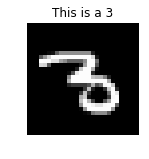

In [5]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (2,10)

def show_digit(img, caption='', subplot=None):
    if subplot == None:
        _, (subplot) = plt.subplots(1,1)
    imgr = img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

## Training

This is a relatively small dataset, but Sagemaker can scale to handle Terrabytes of data in training batches. Below we set the training parameters and resource configuration, launch a job, and check its status.

### Note on use of Sagemaker

The example below is a "high-level" implementation of Sagemaker's functionality. AWS also offers a more granular approach to training models which allows the user to customize training images, execution plans, etc. We'll show the more granular approach in the Classification lab.

In [6]:
from sagemaker import KMeans

data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_example/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

# set training parameters:
kmeans = KMeans(role=role,
                train_instance_count=2,
                train_instance_type='ml.c4.8xlarge',
                output_path=output_location,
                k=10,
                data_location=data_location)

training data will be uploaded to: s3://mw-simple-data/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://mw-simple-data/kmeans_example/output


In [8]:
%%time
# normalize data:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scl = StandardScaler()
scl.fit(train_set[0])
X_std = scl.transform(train_set[0])

pca = PCA(n_components=16, svd_solver='randomized', whiten=True)
pca.fit(X_std)
X_pca = pca.transform(X_std)
#print(pca.explained_variance_ratio_)

kmeans.fit(kmeans.record_set(train_set[0]))
#kmeans.fit(kmeans.record_set(X_train))

#inspect.getfullargspec(KMeans)[0]
#dir(KMeans)

INFO:sagemaker:Creating training-job with name: kmeans-2018-08-20-21-35-23-448


....................
Docker entrypoint called with argument(s): train
[08/20/2018 21:38:40 INFO 140251329341248] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'_num_slices': u'1'}
[08/20/2018 21:38:40 INFO 140251329341248] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'784', u'k': u'10', u'force_dense': u'True'}
[08/20/2018 21:38:40 INFO 140251329341248] Final configuration: {u'k': u'10', 


Billable seconds: 209
CPU times: user 11.1 s, sys: 1.18 s, total: 12.3 s
Wall time: 4min 26s


In [10]:
# # Transform principal components to images:
# eigen_16 = pca.components_.reshape(16, 28, 28)

# # Plot the first 40 eignenvalues
# plt.figure(figsize=(15,15))
# for i in list(range(16)):
#     plt.subplot(9, 10, i + 1)
#     plt.imshow(eigen_16[i], interpolation = "bicubic", cmap = "afmhot")
#     title_text = 'Eigenvalue ' + str(i + 1)
#     plt.title(title_text, size=12)
#     plt.xticks(())
#     plt.yticks(())

# plt.tight_layout()

## Deployment

Sagemaker includes some awesome functionality to deploy models to HTTPS endpoings via its managed service. This is incredibly simple compared to coding and deploying an API from scratch.

In [9]:
%%time

kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: kmeans-2018-08-20-21-41-38-608
INFO:sagemaker:Creating endpoint with name kmeans-2018-08-20-21-35-23-448


---------------------------------------------------------------!CPU times: user 308 ms, sys: 16 ms, total: 324 ms
Wall time: 5min 19s


## Validation

Now, we can use the endpoint that we just created to find the closest cluster label for any array in the same format as what was fed to the training model! So, we can get a sense for how well the clustering algorithm we built is doing.

### Test endpoint

First query the new endpoint to make sure it's listening and responding to incoming data.

In [14]:
#result = kmeans_predictor.predict(train_set[0][30:31])
result = kmeans_predictor.predict(train_set[0][30:31])
print(result[0])

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 1.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 7.35105037689209
    }
  }
}



### Batch predictions

In [18]:
#%%time 

valid_data = train_set[0][0:100]

#valid_data = pca.transform(valid_set[0][0:100])
result = kmeans_predictor.predict(valid_data)
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]
#valid_data.shape

### Visual evaluation

Note that clustering doesn't care about the meaning of the objects it puts into groups. For this data, it means that we'll get the number of clusters we chose earlier (10), but that the actual labels assigned won't necessarily correspond to the values in the data. So, cluster 0 may or may not contain images from 0's that people wrote.

To evaluate, we're looking for clusters that are consistent internally and distinct from the rest of the data.




Cluster a:


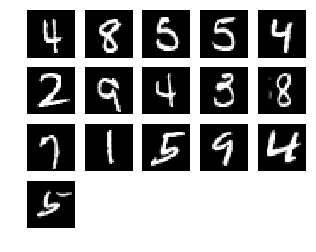




Cluster b:


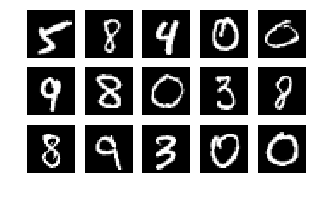




Cluster c:


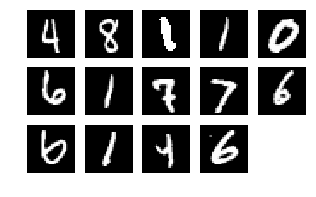




Cluster d:


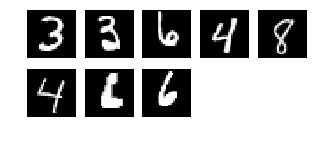




Cluster e:


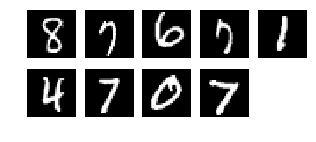




Cluster f:


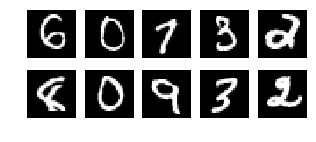




Cluster g:


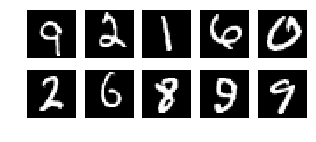




Cluster h:


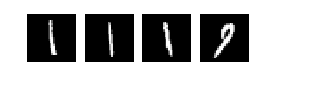




Cluster i:


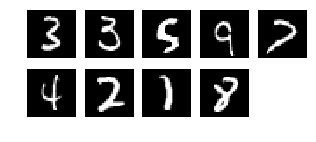




Cluster j:


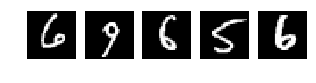

In [19]:
# labels for cluster assignments:
letters = list(map(chr, range(97, 123)))

# show the images that were categorized within each of the 10 clusters:
for cluster in range(10):
    print('\n\n\nCluster {}:'.format(letters[cluster]))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ]
    height = ((len(digits)-1)//5) + 1
    width = 5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots = numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()

### Metrics evaluation

There are some other metrics-driven ways to evaluate the quality of clusters formed. Once the clustering algorithm (K-Means, K-medoids, self-organizing maps, spectral clustering, etc.) is chosen, metrics like the below are typically compared across different numbers of clusters to assess the quality of the results.

* Silhouette width: Evaluates each observation in the dataset through it's average distance from the other data points in the assigned cluster, compared to it's average distance from the data points in the *next closest* cluster. Values above 0 indicate that an observation is correctly assigned.  Below 0 indicate that an observation is probably assigned to the wrong cluster.  

* Within-cluster sum of squares vs. total sum of squares: Indicates the portion of the total variability in the dataset that's captured by cluster assignments.

We'll demo an evaluation using silhouette width next.

More information can be found here for those interested: https://bioinformatics-training.github.io/intro-machine-learning-2017/clustering.html

### Silhouette width

For n_clusters = 10 The average silhouette_score is : -0.008585098


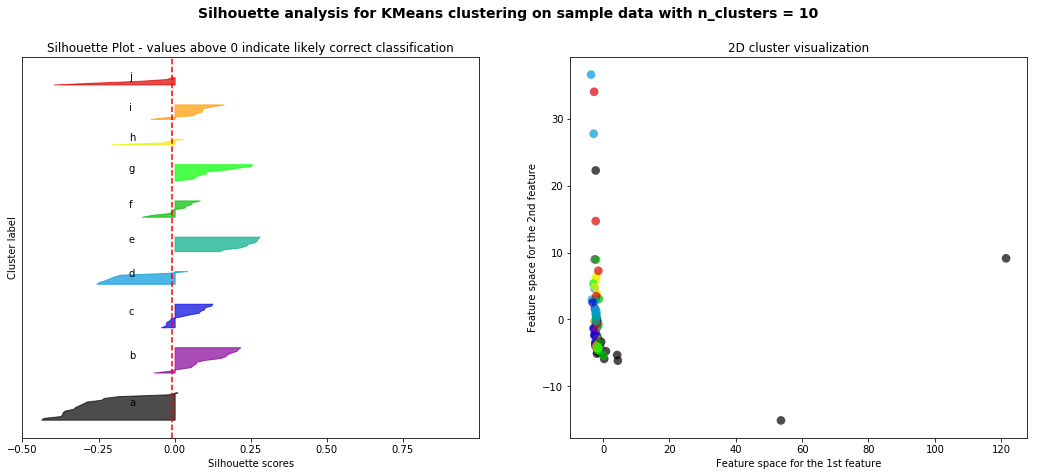

In [20]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

pca = PCA(n_components=2)
X = valid_data
X = scl.transform(X)
X_pcs = pca.fit_transform(X)
cluster_labels_int = np.array(clusters).astype(int)
cluster_labels = np.array([letters[int(item)] for item in clusters])
n_clusters = len(set(cluster_labels))
range_n_clusters = [10]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    letter = letters[i]
    #ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == letter]
    
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    
    y_upper = y_lower + size_cluster_i
    
    
    color = cm.nipy_spectral(float(i) / n_clusters)
    
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.15, y_lower + 0.5 * size_cluster_i, str(letter))
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samp
    
ax1.set_title("Silhouette Plot - values above 0 indicate likely correct classification")
ax1.set_xlabel("Silhouette scores")
ax1.set_ylabel("Cluster label")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.5, -0.25, 0.0, 0.25, 0.5, 0.75])

colors = cm.nipy_spectral(cluster_labels_int.astype(float) / n_clusters)
ax2.scatter(X_pcs[:, 0], X_pcs[:, 1], marker='.', s=300, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

# Labeling the clusters
#centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
#ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#            c="white", alpha=1, s=200, edgecolor='k')

#for i, c in enumerate(centers):
#    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                s=50, edgecolor='k')

ax2.set_title("2D cluster visualization")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % n_clusters),
             fontsize=14, fontweight='bold')
plt.show()

## Summary

Reviewing the silhouette plot, we can see that most data points are assigned to a cluster with other images that are, on average, more similar that those in the next closest cluster. As discussed earlier, the algorithm is only aware of the numeric scores in each pixel and isn't "smart" enough to detect advanced patterns within them. Neural networks are able to learn relationships between data points in that manner, but those are beyond the scope of this introduction.

Additionally, we can see that the clusters aren't all the same size! K-means doesn't attempt to find equally sized clusters. When results are severely unbalanced, it's an indication of 1) outliers in the data or 2) differences in the density of data points (i.e. many points are together in a small space while a few exist further away).

So, K-means isn't an amazingly good classifier for this dataset, but does a decent job.

## Cleanup

Now that we're done evaluating the cluster model, we can remove the endpoint we built from AWS.

In [21]:
# cleanup endpoints once finished:
# Can also manage endpoints through AWS CLI or from the console.
import sagemaker
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: kmeans-2018-08-20-21-35-23-448
